## Agitation Video Analysis 

This notebook may be used as a tool to determine the approximate mixing times of agitated glass vessels.

In [1]:
import imageio as iio; import cv2; import numpy as np; import matplotlib.pyplot as plt; from tqdm import tqdm; import os; import tkinter as tk;
from tkinter import filedialog
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interactive
import pandas as pd

In [2]:
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(filetypes=[("MP4 files", "*.mp4")])
    return file_path

video_name = select_file()
print(f"Selected video file: {video_name}")

2023-10-17 10:22:19.016 python[69481:6383296] +[CATransaction synchronize] called within transaction


Selected video file: /Users/tsavage/Documents/movie.mp4


In [15]:
cap = cv2.VideoCapture(video_name)
success,image = cap.read()
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = int(cap.get(cv2.CAP_PROP_FPS))

## Change the values here to crop the image appropriately

In [4]:
x = len(image[0,:])
y = len(image[:,0])

horizontal_slider = widgets.FloatRangeSlider(
    value=[0,x], 
    min=0., max=x, step=1.,
    description='Horizontal:',
    readout_format='.1f',
)

vertical_slider = widgets.FloatRangeSlider(
    value=[0,y], 
    min=0., max=y, step=1.,
    description='Vertical:',
    readout_format='.1f',
)

def crop(x,y):
    left,right = x 
    top,bottom = y
    left = int(left)
    top = int(top)
    bottom = int(bottom)
    right = int(right)
    print(left,right,top,bottom)
    img = image[top:bottom,left:right]
    plt.imshow(img)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()

interactive_plot = interactive(
    crop, 
    x=horizontal_slider,
    y=vertical_slider
)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatRangeSlider(value=(0.0, 1920.0), description='Horizontal:', max=1920.0, readout_for…

In [13]:
left,right = horizontal_slider.value
top,bottom = vertical_slider.value
left,right,top,bottom = int(left),int(right),int(top),int(bottom)

In [16]:
frame_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=num_frames,
    step=1,
    description='Last Frame:',
    readout_format='.1f',
)


def last_frame(last):
    cap.set(cv2.CAP_PROP_POS_FRAMES, last)
    res, frame = cap.read()
    plt.imshow(frame[top:bottom,left:right])
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()

interactive_plot = interactive(
    last_frame, 
    last=frame_slider
)

output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='Last Frame:', max=3156.0, readout_format='.1f', step…

In [17]:
last = int(frame_slider.value)
print(last)

2087


In [18]:
frames = np.empty((last, bottom-top, right-left), dtype=np.uint8)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
for i in tqdm(range(last)):
    ret, frame = cap.read()
    if ret:
        frames[i] = np.mean(frame[top:bottom,left:right,:],axis=2)
cap.release()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2087/2087 [00:15<00:00, 132.72it/s]


In [19]:
mean = np.mean(frames,axis=(1,2)); std = np.std(frames,axis=(1,2))

In [20]:
quantiles = [0, 10,20,30,40,50,60,70,80,90,100]
result = []

for frame in tqdm(frames):
    frame_quantiles = [np.percentile(frame, q) for q in quantiles]
    result.append(frame_quantiles)

result = np.array(result)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2087/2087 [00:29<00:00, 69.87it/s]


In [21]:
seconds = np.arange(len(mean))/fps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


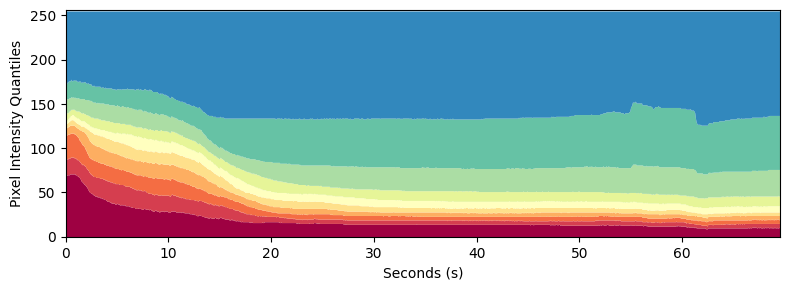

In [26]:
try:
    os.mkdir('results')
except:
    pass

fig,ax = plt.subplots(1,1,figsize=(8,3),sharex=True)

ax.legend(frameon=False)
ax.set_xlim(0,seconds[-1])
ax.set_xlabel('Seconds (s)')

cols = ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#e6f598', '#abdda4', '#66c2a5', '#3288bd']
for i in range(len(quantiles)-1):
    ax.fill_between(seconds,result[:,i],result[:,i+1],color = cols[i],lw=0)

ax.set_ylabel('Pixel Intensity Quantiles')

ax.legend(frameon=False)
ax.set_ylim(0,256)
fig.tight_layout()
plt.savefig('results/plot.png',dpi=600)

plt.show()

In [27]:
res_df = {'Time (s)':seconds,'Frame Intensity (Mean)':mean,'Frame Intensity (Standard Deviation)':std}
for i in range(len(quantiles)):
    res_df[str(quantiles[i])+'% Quantile'] = result[:,i]

df_res = pd.DataFrame(res_df)
df_res.to_csv('results/data.csv',index=False)